# Diseño de solución para predicción de radiación solar en diferentes escalas temporales de la comunidad de Castilla y León, España, para la gestión de proyectos de generación fotovoltaica.

## Visualización de datos

### Integrantes

* Moisés Alfonso Guerrero Jiménez
* Andrés Castaño Licona

### Descripción de los datos

Los datos usados hacen parte de un repositorio abierto con licencia Creative Commons Attribution, que contiene mediciones de radiación solar horizontal global (GHI), recopiladas durante un periodo de 18 años, desde el 1 de enero de 2002 hasta el 31 de diciembre de 2019, con una granularidad de 30 minutos, que fueron medidos en 37 estaciones ubicadas en la región española de Castilla y León.

El conjunto de datos no solo cuenta con datos crudos, sino también con datos refinados y etiquetados por estaciones de medición, contando además con variables meteorológicas y geográficas que complementan el valor de los datos de irradiación.

Los datos fueron publicados por integrantes del Departamento de Ingeniería Topográfica y Cartográfica de la Escuela Técnica Superior de Ingenieros en Topografía, Geodesia y Cartografía, Universidad Politécnica de Madrid, y se encuentran disponibles para su uso con fines de investigación en un repositorio público con nombre “CyL_GHI” disponible en el sitio web Zenodo (https://zenodo.org/records/7404167), y además cuentan con una documentación detallada con nombre “CyL-GHI: Global Horizontal Irradiance Dataset Containing 18 Years of Refined Data at 30-Min Granularity from 37 Stations Located in Castile and León (Spain)”, que describe de manera precisa mucho del preprocesamiento, estandarización y limpieza realizado por los autores, así como muchas de las características del dataset.

La lectura de los datos requiere de un paso inicial de descarga del repositorio de Zenodo, para lo cual se hace uso del comando wget de linux, que nos permite realizar la descarga directamente al directorio de ejecución en Colab.

In [68]:
# Descarga de datos crudos para ser procesados y analizados
! wget https://zenodo.org/records/7404167/files/CyL_raw.zip

# Descarga de los datos geográficos
! wget https://zenodo.org/records/7404167/files/CyL_geo.csv

^C


--2024-03-10 16:44:53--  https://zenodo.org/records/7404167/files/CyL_geo.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2429 (2,4K) [text/plain]
Saving to: 'CyL_geo.csv.1'

     0K ..                                                    100%  386M=0s

2024-03-10 16:44:54 (386 MB/s) - 'CyL_geo.csv.1' saved [2429/2429]



In [ ]:
# For windows unzip
! mkdir CyL_raw
! tar -x -f CyL_raw.zip -C ./CyL_raw/

# For linux unzip
# ! unzip -q CyL_raw.zip -d CyL_raw/

In [ ]:
# For windows list directory
! dir CyL_raw

# For linux list directory
# ! ls -l CyL_raw/

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: DA3E-DFBE

 Directorio de c:\Users\Mois�s Guerrero\OneDrive\UdeA\Visualizacion-Datos\docs\RMarkdown\CyL_raw

06/03/2024  20:13    <DIR>          .
06/03/2024  20:13    <DIR>          ..
18/03/2022  13:39    <DIR>          2002
18/03/2022  13:39    <DIR>          2003
18/03/2022  13:40    <DIR>          2004
18/03/2022  13:40    <DIR>          2005
18/03/2022  13:41    <DIR>          2006
18/03/2022  13:41    <DIR>          2007
18/03/2022  13:41    <DIR>          2008
18/03/2022  13:42    <DIR>          2009
18/03/2022  13:42    <DIR>          2010
18/03/2022  13:43    <DIR>          2011
18/03/2022  13:44    <DIR>          2012
18/03/2022  13:44    <DIR>          2013
18/03/2022  13:45    <DIR>          2014
18/03/2022  13:46    <DIR>          2015
18/03/2022  13:47    <DIR>          2016
18/03/2022  13:48    <DIR>          2017
18/03/2022  13:49    <DIR>          2018
18/03/2022  13:49    <DIR>         

Tal como se observa, los datos crudos se encuentran almacenados en subcarpetas referentes a cada año de mediciones realizadas entre el 2002 y el 2019.

Una revisión manual desde el explorador permite observar que cada subcarpeta cuenta con archivos en formato zip que contienen archivos en formato csv con las mediciones realizadas a lo largo de un día.

Los archivos comprimidos por día, son facilmente identificables por medio de un prefijo que indica la fecha en la cual se realizaron las mediciones de acuerdo al patrón `YYYYMMDD_RedClimaITACYL_Horario.zip`, donde `YYYYMMDD` corresponde al día de mediciones para el año de cada subcarpeta.

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

### Extracción transformación y carga de los datos

Dado que se requiere visualizar y entender la forma en la cual se encuentran distribuidas las distintas variables medidas en el conjunto de datos, es necesario realizar un proceso de extracción, transformación y carga de la información relevante para el proceso en cuestión, para lo cual se realiza primero una descompresión dinámica de cada uno de los archivos csv almacenados por cada zip en los subdirectorios antes mencionados

In [ ]:
# Creamos un listado de los años en los cuales se tienen mediciones
# En este caso solo se trabajará con una muestra de los 3 primeros años
# years = range(2002, 2020, 1) # 2002 - 2019
years = range(2002, 2005, 1) # 2002 - 2004

# Creamos un directorio temporal donde se almacenarán los datos csv extraídos de cada subdirectorio
os.makedirs("temp_CyL", exist_ok=True)

# Para cada año se listan todos los archivos zip y se ejecuta un comando que los extrae en un subdirectorio en temp_CyL
for year in years:
    print(f"Listando archivos para el año {year}...")
    # Usamos la librería os para listar los archivos en el directorio CyL_raw/
    files_list = os.listdir(f"CyL_raw/{year}/")
    # Para cada archivo incluido en el listado ejecutamos un comando de descompresión por medio de os
    for file in files_list:
        # For windows
        os.makedirs(f"temp_CyL/{year}/", exist_ok=True)
        os.popen(f"tar -x -f CyL_raw/{year}/{file} -C temp_CyL/{year}/")
        # For linux
        # os.popen(f"unzip -q CyL_raw/{year}/{file} -d temp_CyL/{year}/")

Listando archivos para el año 2002...
Listando archivos para el año 2003...
Listando archivos para el año 2004...


De acuerdo a la documentación del dataset, las mediciones fueron realizadas en un total de 37 estaciones meteorológicas, por lo cual es necesario realiza la extracción de los datos por cada estación meteorológica en cada día.

In [ ]:
# Primero se obtiene la tabla que relaciona las 37 estaciones meteorológicas con dataframe de pandas
df_geo = pd.read_csv("CyL_geo.csv", header = 0, sep = ',', index_col=0)
df_geo.head()

,station_code,name,latitude,longitude,height
0,AV01,Nava de Arévalo,40.968828,-4.767943,921
1,BU02,Valle de Valdelucio,42.746260,-4.132867,976
2,BU03,Lerma,42.039658,-3.768196,840
3,BU04,Tardajos,42.346138,-3.802584,822
4,BU05,Vadocondes,41.637103,-3.576803,811


In [ ]:
df_geo.dtypes

station_code     object
name             object
latitude        float64
longitude       float64
height            int64
dtype: object

Los datos crudos cuentan con un encabezado con 10 columnas separadas por punto y coma (;), correspondientes a:

* Código: Código único de la estación en la cual se realizaron las mediciones.
* Ubicación: Indica el nombre de la estación de medición de acuerdo a su ubicación.
* Fecha (AAAA-MM-DD): Hace referencia a la fecha en la cual se realizaron las mediciones (UTC).
* Hora (HHMM): Indica la hora en la cual se realizó la medición para la fecha correspondiente (UTC).
* Precipitación (mm): Precipitaciones medidas en milímetros en la ubicación de la estación de medición.
* Temperatura (°C): Temperatura en grados celsius medida en la ubicación de la estación meteorológica.
* Humedad relativa (%): Indica el porcentaje de humedad medido.
* Radiación (W/m2): Medición de la radiación solar global horizontal (GHI).
* Vel. viento (m/s): Velocidad del viento medida en $m/s$
* Dir. viento (°): Dirección del viento en grados.

Sin embargo, se observan caracteres especiales que sugieren que el archivo debe ser leído con una codificación diferente a UTF-8. De acuerdo a la documentación disponible en https://docs.python.org/3/library/codecs.html#standard-encodings, hacemos uso de una codificación latin-1, lo que permite visualizar correctamente los datos al ser leídos.

Tal como se observa a continuación al intentar leer el archivo con la codificación por defecto no es posible leer el archivo.

In [ ]:
try:
    # Ejemplo de archivo leído con utf-8
    df_ex_encoding = pd.read_csv("temp_CyL/2002/20020101_RedClimaITACYL_Horario.csv", header=0, sep=';', encoding='utf-8')
except Exception as e:
    print(f"No fue posible leer el archivo con la codificación 'utf-8' debido a: \n{e}")
    print("Leyendo archivo con codificación 'latin-1'...")
    df_ex_encoding = pd.read_csv("temp_CyL/2002/20020101_RedClimaITACYL_Horario.csv", header=0, sep=';', encoding='latin-1')

df_ex_encoding.head(5)

No fue posible leer el archivo con la codificación 'utf-8' debido a: 
'utf-8' codec can't decode byte 0xf3 in position 1: invalid continuation byte
Leyendo archivo con codificación 'latin-1'...


,Código,Ubicación,Fecha (AAAA-MM-DD),Hora (HHMM),Precipitación (mm),Temperatura (ºC),Humedad relativa (%),Radiación (W/m2),Vel. viento (m/s),Dir. viento (º)
0,AV01,Nava de Arévalo,2002-01-01,30,0.0,8.67,81.8,0.0,2.27,142.8
1,AV01,Nava de Arévalo,2002-01-01,100,0.0,8.54,82.6,0.0,2.37,148.0
2,AV01,Nava de Arévalo,2002-01-01,130,0.0,8.60,82.9,0.0,2.29,153.2
3,AV01,Nava de Arévalo,2002-01-01,200,0.0,8.49,83.4,0.0,1.51,156.7
4,AV01,Nava de Arévalo,2002-01-01,230,0.0,7.91,85.1,0.0,1.15,157.4


In [ ]:
# Construimos una función que nos permita hacer el preprocesamiento de cada dataframe para ser unificados
def preprocesamientoDatos(path):
    """
    Realiza la lectura y el preprocesamiento de los datos para ser estandarizados
    """
    # Se realiza la lectura con una codificación "latin-1" para lectura de los caracteres especiales
    df = pd.read_csv(path, header=0, sep=';', encoding='latin-1')

    # Actualización de los nombres de las columnas
    df.rename(columns={
        "Código": "station_code",
        "Ubicación": "station_name",
        "Fecha (AAAA-MM-DD)": "date",
        "Hora (HHMM)": "time",
        "Precipitación (mm)": "precipitation",
        "Temperatura (ºC)": "air_temp",
        "Humedad relativa (%)": "humidity",
        "Radiación (W/m2)": "GHI",
        "Vel. viento (m/s)": "wind_sp",
        "Dir. viento (º)": "wind_dir"
    }, inplace=True)

    # Dado que pandas autimáticamente interpreta los tipos de dato se realizan transformaciones a los mismos
    # Llenamos los 4 caracteres de la hora
    df['time']  = df.time.astype(str).str.zfill(4)

    # Creamos una marca de tiempo a partir de los datos de fecha y hora
    df['timestamp'] = df['date'] + ' ' + df['time']
    # Modificamos aquellos cuya hora se encuentra a las 24:00 que corresponde a 00:00 del día siguiente
    df['timestamp'] = df['timestamp']\
        .apply(lambda x: x if x[-4:] != '2400' else datetime.strftime(datetime.strptime(x[:10], '%Y-%m-%d') + timedelta(1), '%Y-%m-%d') + ' 0000')
    # Convertimos los datos a datetime64
    df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H%M')
    # Borramos las columnas date y time
    df.drop(columns=['date', 'time'])
    return df

In [ ]:
# Para cada archivo por cada subcarpeta, realizamos la unificación temporal de los datos a un único DataFrame

df_general = pd.DataFrame() # Dataframe vacío
for year in years:
    print(f"Cargando archivos para el año {year}...")
    # Usamos la librería os para listar los archivos en el directorio temp_CyL/
    files_list = os.listdir(f"temp_CyL/{year}/")
    # Para cada archivo incluido en el listado realizamos una lectura y preprocesamiento
    for file in files_list:
        df_temp = preprocesamientoDatos(f"temp_CyL/{year}/{file}")
        df_general = pd.concat([df_general, df_temp])

# Verificamos el df_general creado
print(f"Dimensiones del dataframe general creado: {df_general.shape}")

Cargando archivos para el año 2002...
Cargando archivos para el año 2003...
Cargando archivos para el año 2004...
Dimensiones del dataframe general creado: (2205519, 11)


### Obtención de radiación solar incidente teórica

Con el objetivo de complementar el conjunto de datos, se busca mediante el desarrollo de una función obtener la radiación solar incidente teórica para una latitud y longitud específicas.

De acuerdo a lo comentado en "[Cálculo de la radiación solar extraterrestre en función de la latitud y la declinación solar](https://m.riunet.upv.es/bitstream/handle/10251/68296/Bautista%20-%20C%C3%A1lculo%20de%20la%20radiaci%C3%B3n%20solar%20extraterrestre%20en%20funci%C3%B3n%20de%20la%20latitud%20y%20la%20declinaci%C3%B3n....pdf?sequence=1&isAllowed=y)" es posible obtener dicho valor mediante ecuaciones que describen la radiación solar teórica extraterreste.

Por medio del dataframe de datos geográficos `df_geo`, podemos hacer uso de las latitudes y longitudes específicas de cada estación de medición y de esta manera complementar los datos para cada estación meteorológica.

In [ ]:
def radiacion_solar_S0(dia_anho):
    """
    Obtiene el valor del parámetro solar S0 o densidad de flujo de la radiación
    que se recibe sobre una superficie perpendicular a los rayos solares para
    un día del año de 1 a 365.
    """
    dia_ref = 81  # 22 de marzo
    if dia_anho < 81:
        D = 365 - dia_ref + dia_anho
    else:
        D = dia_anho - dia_ref
    constante_solar = 1367.
    distancia_media_sol = 149597870000.  # metros

    d = (1.496 * 10 ** 11) * (1 - 0.017 * math.sin(math.radians(0.9856 * D)))
    return constante_solar * ((distancia_media_sol / d) ** 2)

def declinacion_solar(dia_anho):
    """
    Obtiene la posición relativa del sol respecto a la superficie de la tierra
    en un día específico del año de 1 a 365.
    """
    return 23.5 * math.cos(math.radians((360 * (dia_anho - 172) / 365.)))

def hora_solar(dia_anho, hora, longitud, longitud_del_huso, adelanto_hora_verano=0):
    """
    Realiza una corrección astronómica de la hora del día convencional
    transformandola en la hora solar.
    """
    M = dia_anho * 2. * math.pi / 365.24
    EoT = 229.19 * (-0.0334 * math.sin(math.radians(M)) + 0.04184 * math.sin(math.radians(2 * M + 3.5884)))
    return 15 * (hora - adelanto_hora_verano - 12) + (longitud - longitud_del_huso) + EoT / 4.0

def radiacion_solar_teorica(dia, hora, latitud, longitud, longitud_huso_horario, hora_verano=0):
    """
    Obtiene la radiación solar teórica para un punto de la tierra, teniendo en
    cuenta la ubicación geográfica, la declinación, el parámetro solar S0 y la
    hora solar.
    """
    S0 = radiacion_solar_S0(dia)
    inc = declinacion_solar(dia)
    w = hora_solar(dia, hora, longitud, longitud_huso_horario, hora_verano)
    S = S0 * math.sin(math.radians(90 - latitud + inc)) * math.cos(math.radians(w))
    return S if S>=0 else 0
     

El siguiente ejemplo toma los datos de la estación de medición en Nava de Arévalo (AV01) y a partir de la latitud y longitud, así como la longitud del uso horario, permite obtener valores de GHI teórico.

In [ ]:
longitud_huso = 0 # Longitud del huso horario en españa

# A partir de las funciones, adicionamos una columna de radiación teórica
df_test = df_general[df_general.station_code == 'AV01'].copy()
df_test.head()

,station_code,station_name,date,time,precipitation,air_temp,humidity,GHI,wind_sp,wind_dir,timestamp
0,AV01,Nava de Arévalo,2002-01-01,0030,0.0,8.67,81.8,0.0,2.27,142.8,2002-01-01 00:30:00
1,AV01,Nava de Arévalo,2002-01-01,0100,0.0,8.54,82.6,0.0,2.37,148.0,2002-01-01 01:00:00
2,AV01,Nava de Arévalo,2002-01-01,0130,0.0,8.60,82.9,0.0,2.29,153.2,2002-01-01 01:30:00
3,AV01,Nava de Arévalo,2002-01-01,0200,0.0,8.49,83.4,0.0,1.51,156.7,2002-01-01 02:00:00
4,AV01,Nava de Arévalo,2002-01-01,0230,0.0,7.91,85.1,0.0,1.15,157.4,2002-01-01 02:30:00


In [ ]:
latitude = df_geo[df_geo.station_code == 'AV01']['latitude'].iloc[0]
longitude = df_geo[df_geo.station_code == 'AV01']['longitude'].iloc[0]

df_test['theoretical_radiation'] = df_test.apply(lambda row : radiacion_solar_teorica(row['timestamp'].dayofyear,
                     row["timestamp"].hour + row["timestamp"].minute/60., latitude, longitude, longitud_huso), axis = 1)

df_test

,station_code,station_name,date,time,precipitation,air_temp,humidity,GHI,wind_sp,wind_dir,timestamp,theoretical_radiation
0,AV01,Nava de Arévalo,2002-01-01,0030,0.0,8.67,81.8,0.0,2.27,142.8,2002-01-01 00:30:00,0.0
1,AV01,Nava de Arévalo,2002-01-01,0100,0.0,8.54,82.6,0.0,2.37,148.0,2002-01-01 01:00:00,0.0
2,AV01,Nava de Arévalo,2002-01-01,0130,0.0,8.60,82.9,0.0,2.29,153.2,2002-01-01 01:30:00,0.0
3,AV01,Nava de Arévalo,2002-01-01,0200,0.0,8.49,83.4,0.0,1.51,156.7,2002-01-01 02:00:00,0.0
4,AV01,Nava de Arévalo,2002-01-01,0230,0.0,7.91,85.1,0.0,1.15,157.4,2002-01-01 02:30:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43,AV01,Nava de Arévalo,2004-12-31,2200,0.0,4.92,93.5,0.0,1.23,96.0,2004-12-31 22:00:00,0.0
44,AV01,Nava de Arévalo,2004-12-31,2230,0.0,4.97,94.1,0.0,1.17,111.5,2004-12-31 22:30:00,0.0
45,AV01,Nava de Arévalo,2004-12-31,2300,0.0,5.08,93.2,0.0,1.65,110.9,2004-12-31 23:00:00,0.0
46,AV01,Nava de Arévalo,2004-12-31,2330,0.0,5.19,92.7,0.0,1.74,122.8,2004-12-31 23:30:00,0.0


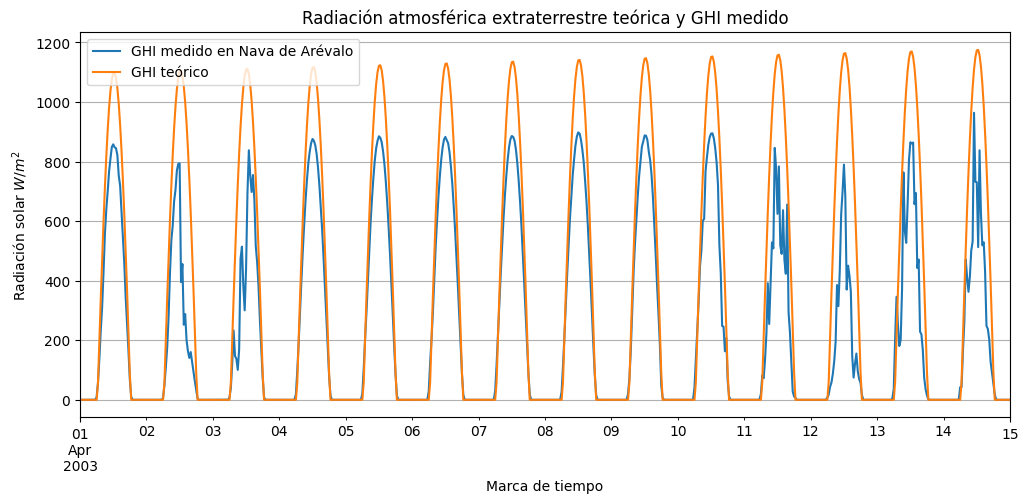

In [ ]:
df_test[df_test.timestamp.between('2003-04-01', '2003-04-15')].plot(x = 'timestamp', y = ['GHI', 'theoretical_radiation'], figsize = (12, 5))
plt.title("Radiación atmosférica extraterrestre teórica y GHI medido")
plt.xlabel("Marca de tiempo")
plt.ylabel("Radiación solar $W/m^{2}$")
plt.grid()
plt.legend([f"GHI medido en {df_test.station_name.unique()[0]}", "GHI teórico"])
plt.show()
     

### Análisis descriptivo de los datos

In [ ]:
# Ejemplo año 2002 estación AV01 Nava de Arévalo
latitud = df_geo[df_geo.station_code == 'AV01']['latitude'].iloc[0]
longitud = df_geo[df_geo.station_code == 'AV01']['longitude'].iloc[0]

# Se genera una matriz de ceros 366 (año bisiesto) días por 24 horas
radiacion_theo = np.zeros((366, 24))

# Se actualizan los valores de la matriz de acuerdo la radiación solar teórica
for i, dia in enumerate(np.arange(0, 366)):
    for j, hora in enumerate(np.arange(0, 24)):
        s = radiacion_solar_teorica(dia, hora, latitud, longitud, longitud_huso)
        if s < 0:
            s = 0
        radiacion_theo[i][j] = s

In [ ]:
df_grouped = df_test.groupby([df_test['timestamp'].dt.date, df_test['timestamp'].dt.hour])[['GHI']].mean().copy()
df_grouped.index.names = ['DateLocal', 'HourLocal']
df_grouped.reset_index(inplace = True)
df_grouped['DayOfYear'] = pd.to_datetime(df_grouped['DateLocal'], format='%Y-%m-%d').dt.strftime('%j').astype(int)

radiacion = np.zeros((366, 24)) # 366 días dado que es un año bisiesto
for _, row in df_grouped.iterrows():
    radiacion[row['DayOfYear']-1][row['HourLocal']] = row['GHI']

NameError: name 'radiacion' is not defined

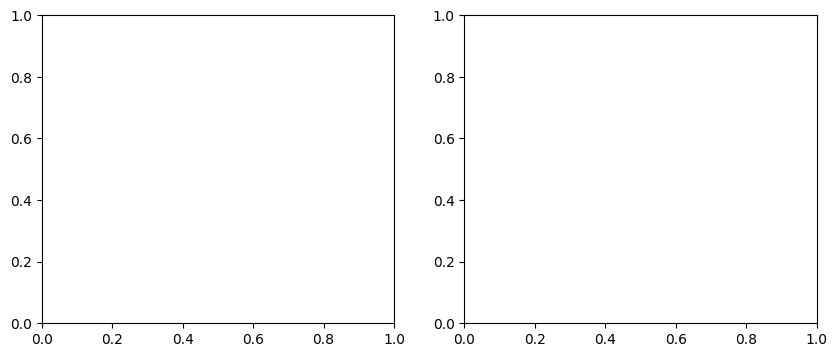

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de radiación solar medida
im = axs[0].imshow(radiacion, aspect='auto', cmap='hot')
axs[0].set_xlabel('Hora')
axs[0].set_ylabel('Día')
axs[0].set_title('Radiación solar medida [W/m^2]')
axs[0].grid(False)

# Gráfico de radiación solar teórica
im2 = axs[1].imshow(radiacion_theo, aspect='auto', cmap='hot')
axs[1].set_xlabel('Hora')
axs[1].set_title('Radiación solar teórica [W/m^2]')
axs[1].grid(False)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [ ]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf

In [ ]:
df_geo = pd.read_csv("CyL_geo.csv", header = 0, sep = ',', index_col=0)
df_geo.head()

,station_code,name,latitude,longitude,height
0,AV01,Nava de Arévalo,40.968828,-4.767943,921
1,BU02,Valle de Valdelucio,42.746260,-4.132867,976
2,BU03,Lerma,42.039658,-3.768196,840
3,BU04,Tardajos,42.346138,-3.802584,822
4,BU05,Vadocondes,41.637103,-3.576803,811


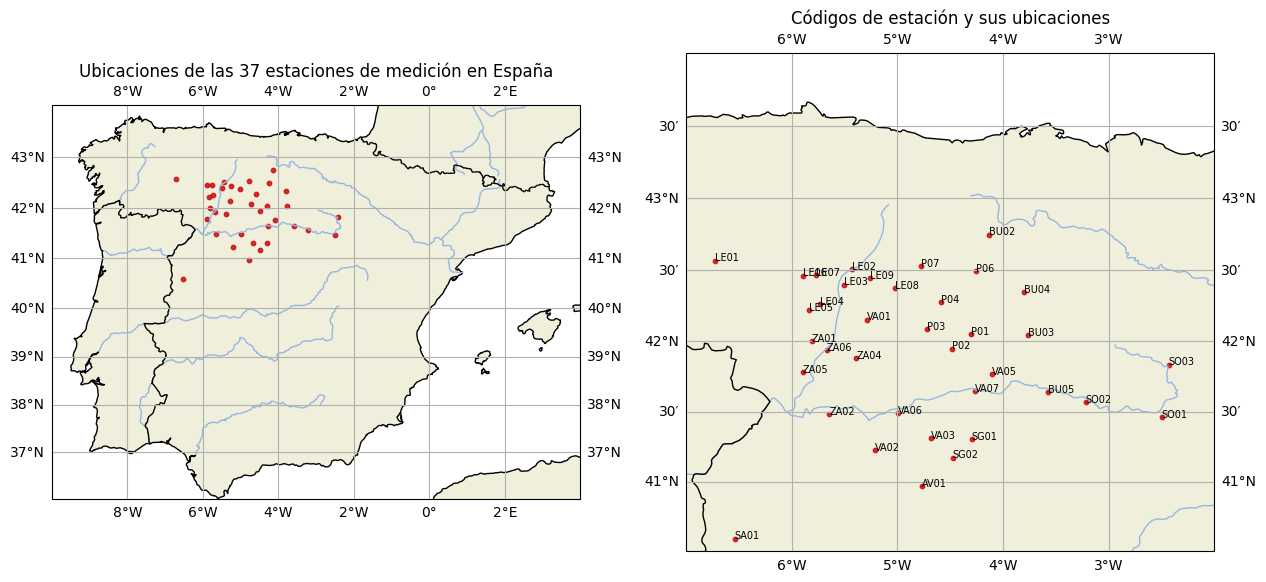

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.Mercator()})

ax[0].set_extent([-10, 4, 36, 44])
ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);
ax[0].add_feature(cf.COASTLINE)
ax[0].add_feature(cf.LAND)
ax[0].add_feature(cf.RIVERS)
ax[0].add_feature(cf.BORDERS)

ax[0].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[0].set_title('Ubicaciones de las 37 estaciones de medición en España')

ax[1].set_extent([-7, -2, 40.5, 44])
ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);
ax[1].add_feature(cf.COASTLINE)
ax[1].add_feature(cf.LAND)
ax[1].add_feature(cf.RIVERS)
ax[1].add_feature(cf.BORDERS)
ax[1].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[1].set_title('Códigos de estación y sus ubicaciones')

for index, row in df_geo.iterrows():
  ax[1].annotate(text=row['station_code'], xy=(row['longitude'], row['latitude']), fontsize=7, transform=ccrs.PlateCarree())
plt.show()

In [ ]:
df_test

NameError: name 'df_test' is not defined